In [1]:
import tensorflow as tf
import numpy as np

import matplotlib.pyplot as plt

%matplotlib inline

writer = tf.summary.FileWriter('./')

In [2]:
h = tf.constant(0.1)
c = tf.constant(0.1)
ve = tf.constant(0.)
decay_constant = tf.constant(0.1)
threshold = tf.constant(10.0)
reset = tf.constant(-3.)


num_iterations = 10000
num_neurons = 2

In [3]:
syn_cons = tf.constant(0.15)
syn_peak = tf.constant(50.0)

#### Sparse Matrix for Synapse Connections

In [4]:
syn_conecs = tf.SparseTensor(indices=[[1, 0]], values=[1.],
                             dense_shape=[2, 2])

#### Single Step for a Neuron Layer

In [5]:
def neuron(y_prev, current_input):    
    # neuron outputs for this step
    y_out = c*(ve - y_prev) + current_input
    return y_out

def neuron_2(y_prev, current_input):
    # neuron outputs for this step
    y_out = c*(ve - y_prev) + current_input
    return y_out

In [6]:
def get_step_input(current_input, step_no):
    if step_no == 1:
        return current_input
    elif step_no > 1:
        return  decay_constant * current_input

In [7]:
def neuron_combined_steps(prev_state, ext_current):
    y_prev = prev_state[0]
    syn_prev = prev_state[1] + ext_current
    
    current_input = get_step_input(syn_prev, 1)
    step1 = neuron(y_prev, current_input)
    
    current_input = get_step_input(current_input, 2)
    step2 = neuron(step1*h/2, current_input)
    
    #current_input = get_step_input(current_input, 2)
    step3 = neuron(step2*h/2, current_input)
    
    current_input = get_step_input(current_input, 2)
    step4 = neuron(step3*h, current_input)
    
    y_out = 1/6*(step1 + 2*step2 + 2*step3 + step4)*h + y_prev
    
    # synapase discharges
    syn_out =  syn_cons * tf.sparse_tensor_dense_matmul(syn_conecs,
        tf.reshape(tf.where(tf.greater(y_out, threshold), syn_peak*tf.ones_like(y_out), syn_prev), (num_neurons,1)))
    
    # peak thresholding for neuron outputs
    y_out = tf.where(tf.greater(y_out, threshold), reset*tf.ones_like(y_out), y_out)

    
    return [y_out, tf.reshape(syn_out,(num_neurons,))]

In [8]:
# inputs to the neurons
inp = 0.05
inputs = tf.Variable(np.array([[inp] + [0.]*(num_neurons-1)] * num_iterations), dtype=tf.float32)

# initial activations and the combined input from synaptic connections
initial_val = 20.
initial_state = [tf.Variable(np.array([initial_val]*num_neurons), dtype=tf.float32),
                 tf.Variable(np.array([0]*num_neurons), dtype=tf.float32)]

# recurrent execution. will iterate to the size of the inputs
out = tf.scan(neuron_combined_steps, inputs, initializer=initial_state)

In [9]:
%%time
# running the tensorflow graph
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    writer.add_graph(sess.graph)
    iteration_vals = sess.run(out)
    print(iteration_vals[1][-1])

[ 0.      0.0075]
CPU times: user 3.7 s, sys: 2.45 s, total: 6.15 s
Wall time: 2.6 s


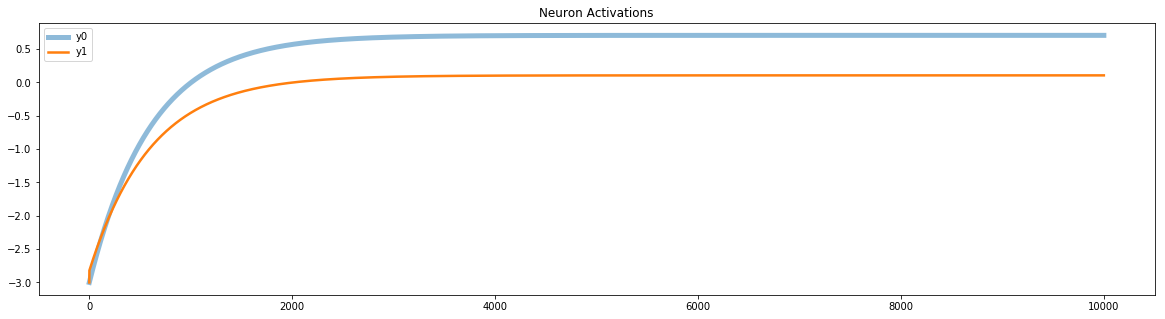

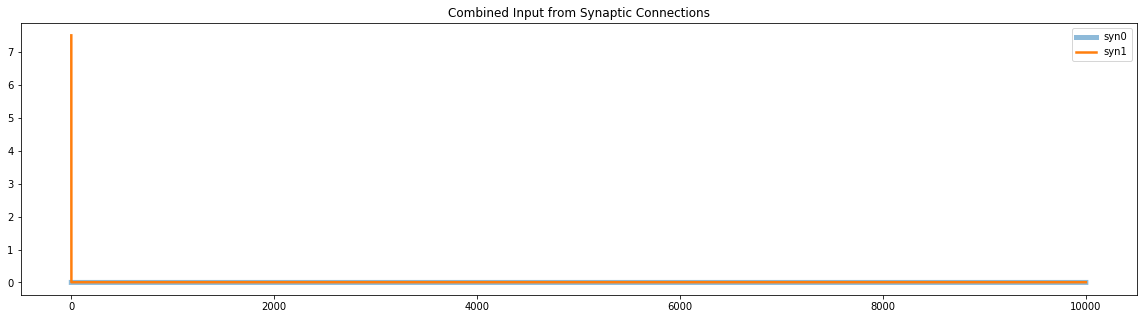

In [10]:
plt.figure(figsize=(20,5))
plt.title('Neuron Activations')
for i in range(num_neurons):
    plt.plot([y[i] for y in iteration_vals[0]], label='y'+str(i), alpha=(i+1.0)/(num_neurons),
             linewidth=5*(num_neurons-i)/(num_neurons))
plt.legend()
plt.show()

plt.figure(figsize=(20, 5))
plt.title('Combined Input from Synaptic Connections')
for i in range(num_neurons):
    plt.plot([y[i] for y in iteration_vals[1]], label='syn'+str(i), alpha=(i+1.0)/(num_neurons),
             linewidth=5*(num_neurons-i)/(num_neurons))
plt.legend()
plt.show()